# Bayesian Quantile Regression

Here are some experiments to use a BNN to approximate a conditional quantile function $Q_Y(\tau \vert \mathbf{x}) \approx f_\theta(\tau, \mathbf{x})$.

In [2]:
import math
import torch as t
from torch.distributions import Normal, Gamma
from torch.distributions.multivariate_normal import MultivariateNormal
import torch.nn as nn
import torch.nn.functional as F
import bayesfunc as bf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from ipywidgets import interact_manual, interact, FloatSlider, IntSlider

dtype=t.float64
device="cpu"

## Toy Data

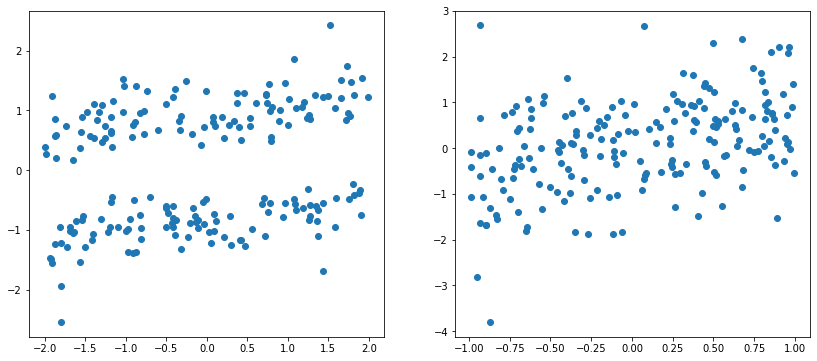

In [3]:
in_features = 1
out_features = 1
train_batch = 40
batches = 5
data_size = batches * train_batch

t.manual_seed(0)

def generate_data_1():
    noise = Gamma(5, 0.2)
    X = t.rand(data_size, in_features) * 4 - 2
    x_1 = X[:int(data_size/2), :]
    x_2 = X[int(data_size/2):, :]
    
    y = t.cat((
        x_1**3 + 5 + 0.5 * noise.sample([int(data_size/2), in_features]),
        x_2**3 - 5 - 0.5 * noise.sample([int(data_size/2), in_features])
    ))

    scale = y.std()
    y = y/scale
    
    # shuffle dataset...
    # TODO remove this: the model should fit the data regardless of its permutation.
    xys = t.cat((X,y), 1)
    xys = xys[t.randperm(xys.size()[0])]
    X = xys[:,0].unsqueeze(1).to(device=device, dtype=dtype)
    y = xys[:,1].unsqueeze(1).to(device=device, dtype=dtype)
    return X, y, scale

def generate_data_2():
    X = t.rand(data_size, in_features) * 2 - 1
    #y = X**3 + X * noise.sample((data_size, in_features))
    
    noise = Normal(0, 1)
    y = X + noise.sample((data_size, in_features))
    
    scale = y.std()
    y = y/scale
    
    xys = t.cat((X,y), 1)
    xys = xys[t.randperm(xys.size()[0])]
    X = xys[:,0].unsqueeze(1).to(device=device, dtype=dtype)
    y = xys[:,1].unsqueeze(1).to(device=device, dtype=dtype)
    return X, y, scale
    
    return X.to(device=device, dtype=dtype), y.to(device=device, dtype=dtype), scale
    
X, y, scale = generate_data_1()
X1, y1, scale1 = generate_data_2()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))#, dpi=100)

ax1.scatter(X.detach(),y.detach())
ax2.scatter(X1.detach(), y1.detach())

## Frequentist Neural Network Approach

Here is an example of what's being done in, for instance, _Autoregressive Quantile Networks for Generative Modelling_ (Ostrovski, Dabney, and Munos 2018), and _Learning Policies through Quantile Regression_ (Richter and Wattenhofer 2019).

The loss function here is the '_expected quantile loss_'
$$
\mathcal{L}_{QR} = \mathbb{E}_{\tau \sim U(0,1)}\left[\mathbb{E}_{(\mathbf{x}, y)\sim \mathcal{D}}\left[\rho_{\tau}\big(y - f_\theta(\tau; \mathbf{x})\big)\right]\right],
$$
where $\rho_\tau(u)$ is
$$
\rho_{\tau}(u) = u\big(\tau - \mathbb{I}_{(u<0)}\big)
$$

In [7]:
data_X = X
data_y = y
scale = scale

ffnet = nn.Sequential(
    nn.Linear(in_features=2, out_features=50, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=50, out_features=1, bias=True)
)
ffnet = ffnet.to(device=device, dtype=dtype)

def rho(tau, u):
    """Quantile regression loss"""
    mask = t.where(u.detach() < 0, t.tensor([1]), t.tensor([0]))
    return u * (tau - mask)

# This is the number of times we will evaluate a random quantile for each batch.
tau_samples = 10
opt = t.optim.Adam(ffnet.parameters(), lr=0.05)
for i in tqdm(range(200)):
    for b in range(batches):
        l = b * train_batch
        u = l + train_batch
        #taus = t.rand(tau_samples).repeat_interleave(train_batch).unsqueeze(1).to(device=device, dtype=dtype)
        taus = t.rand((tau_samples * train_batch, 1)).to(device=device, dtype=dtype)
        taus = t.log((taus/(1-taus)))
        batch_X = t.cat((
            data_X[l:u,0].repeat(tau_samples).unsqueeze(1),
            taus
        ), 1)
        batch_y = data_y[l:u,0].repeat(tau_samples).unsqueeze(1)
        opt.zero_grad()
        output = ffnet(batch_X)
        loss = rho(taus, batch_y - output).mean()
        loss.backward()
        opt.step()

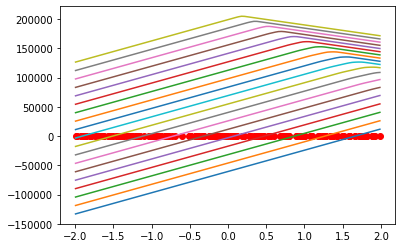

In [9]:
def plot_quantiles_ff(net):
    with t.no_grad():
        num_quantiles = 20
        quantiles = [i * 1/num_quantiles for i in range(1,num_quantiles)]

        # plot the quantile function for each of the n quantiles:
        for q in quantiles: 
            min = data_X.min()
            max = data_X.max()
            xs = t.linspace(min, max, 100)[:, None].to(device=device, dtype=dtype)
            qs =  q * t.ones(xs.shape).to(device=device, dtype=dtype)
            xs = t.cat((xs,qs), 1)
            ys = net(xs)
            plt.plot(xs[:,0].cpu(), ys.cpu())
        plt.scatter(data_X.cpu(), data_y.cpu(), c='r')

plot_quantiles_ff(ffnet)

Having trained the network on the data above, we can now recover the Quantile function, CDF and PDF. For the quantile function:

We can use autodiff to recover the density: the sparsity function is
$$
\frac{\delta}{\delta \tau}F^{-1}_X(\tau) = \frac{1}{p_X(F^{-1}_X(\tau))}.
$$
So we can evaluate the density at known quantiles
$$
p_X\big(F^{-1}_X(\tau)\big) = \frac{1}{\frac{\delta}{\delta \tau} F^{-1}_X(\tau)}
$$

In [7]:
def plot_density_ff(x_loc):
    # The number of points to plot the quantile function at
    N = 80
    taus = t.linspace(0, 1, N).to(dtype=dtype).unsqueeze(1)
    taus = taus.clone().detach().requires_grad_(True)#t.tensor(taus, requires_grad=True)
    xs = t.cat((
        t.tensor([x_loc]).repeat(N).to(dtype=dtype).unsqueeze(1),
        taus
    ), 1).to(device=device)
    
    ys = ffnet(xs)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))#, dpi=100)

    ax1.set_title("FF Network Quantile Function Approx")
    ax1.set_xlabel("tau")
    ax1.set_ylabel("value")
    ax1.plot(taus.detach(), ys.detach().cpu())

    ys.backward(gradient=t.ones_like(taus))

    data = t.cat((taus.detach(), 1/taus.grad), 1).cpu()
    # sort on the y values
    ax2.set_title("FF Network PDF")
    ax2.set_xlabel("value")
    ax2.set_ylabel("density")
    ax2.plot(ys.detach().cpu(), data[:,1])

interact(plot_density_ff, x_loc=FloatSlider(min=data_X.min(), max=data_X.max()))

interactive(children=(FloatSlider(value=0.0, description='x_loc', max=1.9882662296295166, min=-1.9950559139251…

<function __main__.plot_density_ff(x_loc)>

# Bayesian Neural Network approach

Here we use a Bayesian neural network to approximate the full conditional quantile function for all quantiles $\tau \in (0,1)$. That is, we're approximating $Q(\tau \vert \mathbf{x}) = F^{-1}_X(\tau \vert \mathbf{x}) \approx f_\theta(\tau, \mathbf{x})$.

For each input data point $(\tau_i, \mathbf{x}_i)$, the network will output a predicted quantile, $y_i$. The likelihood of this individual output prediction can be obtained by evaluating the double exponential distribution (see, e.g. Yu and Moyeed 2001),
$$
P(y_i \vert \mathbf{x}_i, \tau_i, \mathbf{w}) = \frac{\tau_i (1-\tau_i)}{\sigma}\exp\left\{-\rho_{\tau_i}\left(\frac{y_i - f_{\mathbf{w}}(\tau_i, \mathbf{x}_i)}{\sigma}\right)\right\},
$$
where $\rho_\tau(u)$ is the usual quantile regression loss function, which has the following (potentially more convenient) forms:
\begin{align*}
\rho_{\tau}(u) &= u\big(\tau - \mathbb{I}_{(u<0)}\big) \\
&= u\big(\tau\mathbb{I}_{(u>0)} - (1-\tau)\mathbb{I}_{(u<0)}\big) \\
&= \frac{\vert u \vert + (2\tau - 1)u}{2}.
\end{align*}
The $\tau_i$s are sampled uniformly at random from the unit interval, $\tau_i \sim U(0,1)$.

This 'double exponential distribution' is a normalised probability distribution with scale parameter $\sigma$, which acts similarly to a Gaussian.

For computing the ELBO using a minibatched estimate, we use
$$
\hat{\mathcal{L}}(\phi \vert \mathbf{y}, \vec{\tau}, \mathbf{X}) = \frac{1}{B}\sum^B_{i=1}\log P(y_i \vert \mathbf{x}_i, \tau_i, \mathbf{w}) + \frac{1}{N}\big(\log P(\mathbf{w}) - \log Q_\phi(\mathbf{w})\big),
$$
for $\mathbf{w}$ some weights sampled from the (approximate) posterior.

In [11]:
data_X = X
data_y = y
scale = scale

samples = 10
tau_samples = 10

# Make the minibatches smaller to account for tau_samples
qf_train_batch = 20
qf_batches = int(data_size / qf_train_batch)
qf_data_size = qf_batches* qf_train_batch
assert(qf_data_size == data_size)

inducing_batch=qf_train_batch * tau_samples
bnn = nn.Sequential(
    bf.GILinear(in_features=2, out_features=50, inducing_batch=inducing_batch, bias=True),
    nn.ReLU(),
    bf.GILinear(in_features=50, out_features=1, inducing_batch=inducing_batch, bias=True, full_prec=True)
)
inducing_data = t.cat((
    t.linspace(data_X.min(), data_X.max(), inducing_batch).unsqueeze(1),
    t.linspace(0, 1, inducing_batch).unsqueeze(1)
), 1)
bnn = bf.InducingWrapper(bnn, inducing_batch=inducing_batch, inducing_data=inducing_data)
bnn = bnn.to(device=device, dtype=dtype)

def ALD(tau, scale, us):
    return t.log(tau) + t.log(1-tau) - math.log(scale) - rho(tau, us/scale)

opt = t.optim.Adam(bnn.parameters(), lr=0.05)
for i in tqdm(range(200)):
    for b in range(qf_batches):
        l = b * qf_train_batch
        u = l + qf_train_batch
        
        # randomly sample quantile locations for the batch
        taus = t.rand((qf_train_batch * tau_samples, 1)).to(device=device, dtype=dtype)
        batch_X = t.cat((
            data_X[l:u,0].repeat(tau_samples).unsqueeze(1),
            taus
        ), 1).expand(samples, -1, -1)
        batch_y = data_y[l:u,0].repeat(tau_samples).unsqueeze(1).expand(samples, -1, -1)
        
        opt.zero_grad()
        output, logpq, _ = bf.propagate(bnn, batch_X)
        ll = ALD(taus, 0.1/scale, batch_y - output).mean(1)
        
        # divide by total number of data points we will train with
        lpq = logpq / (data_size * tau_samples)

        elbo = ll.mean() + lpq.mean()

        (-elbo).backward()
        opt.step()


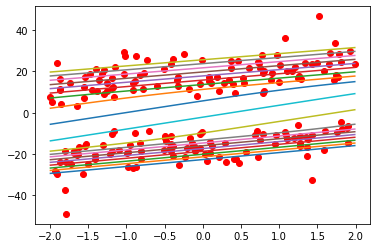

In [12]:
def plot_quantiles(net):
    with t.no_grad():
        num_quantiles = 20
        quantiles = [i * 1/num_quantiles for i in range(1,num_quantiles)]

        # plot the quantile function for each of the n quantiles:
        for q in quantiles:
            min = data_X.min()
            max = data_X.max()
            xs = t.linspace(min, max, 100)[:, None].to(device=device, dtype=dtype)
            qs =  q * t.ones(xs.shape).to(device=device, dtype=dtype)
            xs = t.cat((xs,qs), 1)
            ys, _, _ = bf.propagate(net, xs.expand(100, -1, -1))
            mean_ys = ys.mean(0) * scale
            std_ys = ys.std(0) * scale
            plt.plot(xs[:,0].cpu(), mean_ys.cpu())
            #plt.fill_between(xs[:,0], mean_ys[:,0]-2*std_ys[:,0], mean_ys[:,0]+2*std_ys[:,0], alpha=0.2)
        plt.scatter(data_X.cpu(), data_y.cpu() * scale, c='r')
        
plot_quantiles(bnn)

In [14]:
def plot_density(x_loc):
    # The number of points to plot the quantile function at
    samples = 100
    N = 80
    taus = t.linspace(0, 1, N).unsqueeze(1).expand(100, -1, -1).to(dtype=dtype)
    taus = taus.clone().detach().requires_grad_(True)#t.tensor(taus, requires_grad=True)
    
    xs = t.cat((
        t.tensor([x_loc]).repeat(N).unsqueeze(1).expand(100, -1, -1).to(dtype=dtype),
        taus
    ), 2).to(device=device)
    
    ys, _, _ = bf.propagate(bnn, xs)
    ys_mean = ys.mean(0).squeeze(1)
    
    ys_mean_d = ys_mean.detach().cpu()
    ys_std = ys.std(0).squeeze(1).detach().cpu()
 
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))#, dpi=100)

    ax1.set_title("BNN Quantile Function Approximation")
    ax1.set_xlabel("tau")
    ax1.set_ylabel("value")
    ax1.plot(taus[0].detach(), ys_mean.detach().cpu())
    ax1.fill_between(taus[0].detach().squeeze(1), ys_mean_d - 2 * ys_std, ys_mean_d + 2 * ys_std, alpha=0.2)

    grads = 1/((ys[:,1:] - ys[:,:-1]) / (1/N))
    grads_mean = grads.mean(0).detach().cpu()
    grads_std = grads.std(0).detach().cpu()
    means = (ys_mean[1:] + ys_mean[:-1]) / 2
    ax2.set_ylim(0,1)
    ax2.set_title("PDF")
    ax2.set_xlabel("'return' value")
    ax2.set_ylabel("density")
    ax2.plot(means.detach().cpu(), grads_mean)
    ax2.fill_between(means.detach().cpu(), (grads_mean - 2 * grads_std).squeeze(1), (grads_mean + 2 * grads_std).squeeze(1), alpha=0.2)

interact(plot_density, x_loc=FloatSlider(min=data_X.min(), max=data_X.max()))

interactive(children=(FloatSlider(value=0.0, description='x_loc', max=1.9882662296295166, min=-1.9950559139251…

<function __main__.plot_density(x_loc)>

## A different likelihood

The quantile function which we are approximating implicitly defines a probability distribution. The idea for this new likelihood function is to use the density implied by the quantile function as the likelihood for a data point.

First, recall how we can recover the density from the quantile function:
$$
f_Y(y\vert x) = \frac{1}{\frac{\delta}{\delta \tau}Q_Y(\tau \vert x)}\Bigr\vert_{\substack{\tau = \tau_x(y)}},
$$
where $\tau_x(y)$ is the quantile $\tau$ that solves $y = Q_Y(\tau \vert x)$.

So long as the quantile function $Q_Y(\tau \vert \mathbf{x}) \approx f_\mathbf{w}(\tau, \mathbf{x})$ is monotonically increasing, this ensures that the density is normalised and hence is a valid likelihood.

For the log likelihood used in the ELBO,
$$
\frac{1}{B}\sum_{i=1}^B \log P(y_i \vert \tau_i, \mathbf{x}_i, \mathbf{w}) = -\frac{1}{B}\sum_{i=1}^B \log \frac{\delta}{\delta \tau} Q_Y(\tau_{\mathbf{x}_i}(y_i)\vert \mathbf{x}_i),
$$
which we can approximate by searching through a grid of $\tau \in (0,1)$ values for each input $\mathbf{x}_i$ to identify the interval $(\tau_{i1}, \tau_{i2})$ that contains $\tau_\mathbf{x}(y)$; that is $Q_Y(\tau_{i1}\vert \mathbf{x}_i) \le y_i \le Q_Y(\tau_{i2}\vert \mathbf{x}_i)$.

We can approximate this derivative as
\begin{align*}
\frac{\delta}{\delta \tau} Q_Y(\tau_{\mathbf{x}_i}(y_i)\vert \mathbf{x}_i) &\approx \frac{Q_Y(\tau_{i2} \vert \mathbf{x}_i) - Q_Y(\tau_{i1}\vert \mathbf{x}_i)}{\tau_{i2}-\tau_{i1}} \\
&\approx \frac{f_\mathbf{w}(\tau_{i2}, \mathbf{x}_i) - f_\mathbf{w}(\tau_{i1}, \mathbf{x}_i)}{\tau_{i2} - \tau_{i1}}.
\end{align*}

> The following is very broken. I think this is mostly because there is no mechanism to make our quantile function approximation monotonic in $\tau$, and to range from $-\infty$ at $\tau = 0$, to $\infty$ at $\tau = 1$.

In [86]:
data_X = X
data_y = y
scale = scale

samples = 10
tau_samples = 10

# Make the minibatches smaller to account for tau_samples
qf_train_batch = 20
qf_batches = int(data_size / qf_train_batch)
qf_data_size = qf_batches* qf_train_batch
assert(qf_data_size == data_size)

inducing_batch=(qf_train_batch*tau_samples)
bnn = nn.Sequential(
    bf.GILinear(in_features=2, out_features=50, inducing_batch=inducing_batch, bias=True),
    nn.ReLU(),
    bf.GILinear(in_features=50, out_features=1, inducing_batch=inducing_batch, bias=True, full_prec=True)
)
inducing_data = t.cat((
    t.linspace(0, 1, inducing_batch).unsqueeze(1),    
    t.linspace(data_X.min(), data_X.max(), inducing_batch).unsqueeze(1)
), 1)
bnn = bf.InducingWrapper(bnn, inducing_batch=inducing_batch, inducing_data=inducing_data)
bnn = bnn.to(device=device, dtype=dtype)

def rho(tau, u):
    """Quantile regression loss"""
    mask = t.where(u.detach() < 0, t.tensor([1]), t.tensor([0]))
    return u * (tau - mask)

def ALD(tau, scale, us):
    return t.log(tau) + t.log(1-tau) - math.log(scale) - rho(tau, us/scale)

# This is a hack to make the network outputs initially monotonic...
# TODO: find a way to get rid of this
opt = t.optim.Adam(bnn.parameters(), lr=0.05)
for i in tqdm(range(20)):
    for b in range(qf_batches):
        l = b * qf_train_batch
        u = l + qf_train_batch
        taus = t.rand((qf_train_batch * tau_samples, 1)).to(device=device, dtype=dtype)
        batch_X = t.cat((
            taus,
            data_X[l:u,0].repeat(tau_samples).unsqueeze(1)
        ), 1).expand(samples, -1, -1)
        batch_y = data_y[l:u,0].repeat(tau_samples).unsqueeze(1).expand(samples, -1, -1)
        opt.zero_grad()
        output, logpq, _ = bf.propagate(bnn, batch_X)
        ll = ALD(taus, 1/scale, batch_y - output).mean(1)
        lpq = logpq / (data_size * tau_samples)
        (-(ll + lpq).mean()).backward()
        opt.step()
        
# The number of tau locations used to numerically 'invert' the quantile function
grid_size = 100
# Weight samples from the posterior
samples = 50
        
# perform training using the implied likelihood:
for i in tqdm(range(20)):
    for b in range(batches):
        l = b * train_batch
        u = l + train_batch

        # sample each x in the batch at <grid_size> tau locations:
        taus = t.linspace(0, 1, grid_size).to(device=device, dtype=dtype)
        batch_X = t.cat((
            taus.repeat(train_batch).unsqueeze(1),
            data_X[l:u,0].repeat_interleave(grid_size).unsqueeze(1)
        ),1)
        batch_y = data_y[l:u].squeeze(1)
        
        eval_X = []
        grads = []
        
        # equivalent to taus[1] - taus[0]
        div = 1/(grid_size-1)

        # Here we find the \tau_{x_i}(y_i) points (without saving gradients)
        with t.no_grad():
            output, _, _ = bf.propagate(bnn, batch_X.expand(samples, -1, -1))
            ys = output.mean(0) # average across all the samples from posterior weights
        
            for i in range(train_batch):
                idx = i * grid_size
                x_eval = batch_X[idx,1]
                last_y = ys[idx]
                for j in range(1, grid_size):
                    # The first three if statements here account for cases where the quantile 
                    # function doesn't range from -\infty to \infty...
                    # This would be fixed with a monotonic quantile function approximation,
                    # with the correct range...
                    
                    if ys[idx+j] < last_y:
                        #print("WARNING: non-monotonic output!!")
                        tau_eval = (batch_X[idx+j,0] + batch_X[idx+j-1,0])/2
                        eval_X.append(t.tensor([tau_eval, x_eval]))
                        grads.append(5)
                        break
                    else:
                        last_y = ys[idx+j]
                    if j == 1 and ys[idx] > batch_y[i]:
                        # all predicted points are larger than batch_y[i]:
                        eval_X.append(t.tensor([0.005, x_eval]))
                        grads.append(8)
                        break
                    if j == grid_size-1 and ys[idx+j] < batch_y[i]:
                        # all predicted points are smaller than batch_y[i]:
                        eval_X.append(t.tensor([0.995, x_eval]))
                        grads.append(8)
                        break # not necessary
                    if ys[idx+j-1] <= batch_y[i] and batch_y[i] <= ys[idx+j]:
                        # This is the tau location at the midpoint of the evaluations.
                        tau_eval = (batch_X[idx+j,0] + batch_X[idx+j-1,0])/2
                        eval_X.append(t.tensor([tau_eval, x_eval]))
                        grads.append((ys[idx+j] - ys[idx+j-1])/div)
                        break

        # grads is 1D
        grads = t.tensor(grads).to(device=device, dtype=dtype)

        # double minus is positive
        ll = t.log(grads).mean()
        eval_X = t.cat(eval_X, 0).reshape((len(grads), 2)).expand(samples, -1, -1)

        opt.zero_grad()
        output, logpq, _ = bf.propagate(bnn, eval_X)
        output = output.mean()
        output.backward(ll, retain_graph=True)
        
        elbo = ll + (logpq/data_size).mean()
        (-elbo).backward()
        
        opt.step()

In [ ]:
def plot_quantiles(net):
    with t.no_grad():
        num_quantiles = 20
        quantiles = [i * 1/num_quantiles for i in range(1,num_quantiles)]

        # plot the quantile function for each of the n quantiles:
        for q in quantiles:
            min = data_X.min()
            max = data_X.max()
            xs = t.linspace(min, max, 100)[:, None].to(device=device, dtype=dtype)
            qs =  q * t.ones(xs.shape).to(device=device, dtype=dtype)
            xs = t.cat((qs,xs), 1)
            ys, _, _ = bf.propagate(net, xs.expand(100, -1, -1))
            mean_ys = ys.mean(0) * scale
            std_ys = ys.std(0) * scale
            plt.plot(xs[:,1].cpu(), mean_ys.cpu())
            #plt.fill_between(xs[:,0], mean_ys[:,0]-2*std_ys[:,0], mean_ys[:,0]+2*std_ys[:,0], alpha=0.2)
        plt.scatter(data_X.cpu(), data_y.cpu() * scale, c='r')
        
plot_quantiles(bnn)

# Bayesian Mixture Density Network

Here we approximate the conditional return density for a given state-action pair as a mixture of univariate Gaussians, using a Bayesian mixture density network. The generative model is
$$
p(y\vert\mathbf{x}) = \sum^K_{i=1}\pi_i(\mathbf{x})\mathcal{N}\big(y;\mu_i(\mathbf{x}), \sigma^2(\mathbf{x})\big).
$$
In this case, since we're predicting a return distribution, where the return is a single scalar random variable, we only need to produce a mixture of univariate Gaussians, simplifying things somewhat.

In the above, $K$ is the number of mixture components, and $\sum^K_{i=1}\pi_i(\mathbf{x}) = 1,\ \ \forall \mathbf{x}\in\mathcal{X}$, as well as $\sigma^2_{i}(\mathbf{x}) > 0\ \ \forall \mathbf{x}\in\mathcal{X}$. To ensure these constraints, we pass the mixture weights through a softmax after the final layer, and we can exponentiate the mixture variances after the final layer to ensure positivity.

In [15]:
data_X = X
data_y = y

inducing_batch = 40
# Number of Gaussians
num_gaussians = 2

num_points = samples * data_size * (num_gaussians+2)

class BMDN(nn.Module):
    """Bayesian mixture density network"""
    def __init__(self, inducing_batch, n_gaussians):
        super(BMDN, self).__init__()
        inducing_data = t.linspace(data_X.min(), data_X.max(), inducing_batch).unsqueeze(1)
        self.ia = bf.InducingAdd(inducing_batch=inducing_batch, inducing_data=inducing_data)
        self.ir = bf.InducingRemove(inducing_batch=inducing_batch)
        
        self.fc1 = bf.GILinear(in_features=1, out_features=50, inducing_batch=inducing_batch, bias=True)
        self.pi = bf.GILinear(in_features=50, out_features=n_gaussians, inducing_batch=inducing_batch, bias=True, full_prec=True)
        self.mu = bf.GILinear(in_features=50, out_features=n_gaussians, inducing_batch=inducing_batch, bias=True, full_prec=True)
        self.sigma = bf.GILinear(in_features=50, out_features=n_gaussians, inducing_batch=inducing_batch, bias=True, full_prec=True)
        
    def forward(self, x):
        # Add the inducing points
        x = self.ia(x)
        
        x = t.sigmoid(self.fc1(x))
        
        # apply softmax to mixture weights, exp to variances, 
        # and remove inducing points 
        pi = self.ir(F.softmax(self.pi(x), -1))
        mu = self.ir(self.mu(x))
        sigma = self.ir(t.exp(self.sigma(x)))
        return pi, mu, sigma
        
bmdn = BMDN(inducing_batch, num_gaussians).to(device=device, dtype=dtype)

samples = 20
opt = t.optim.Adam(bmdn.parameters(), lr=0.05)
for i in tqdm(range(1000)):
    for b in range(batches):
        l = b * train_batch
        u = l + train_batch
        batch_X = data_X[l:u].expand(samples, -1, -1)
        batch_y = data_y[l:u].expand(samples, -1, -1)
                
        (pi, mu, sigma), logpq, _ = bf.propagate(bmdn, batch_X)

        # Draw the densities of each individual gaussian
        desities = t.exp(Normal(mu, sigma).log_prob(batch_y))
        # multiply the densities by the mixture weights:
        components = desities * pi
        # add each of the components
        mix = components.sum(-1)
        # find average of log likelihood
        ll = t.log(mix).mean(-1)
        
        assert ll.shape == (samples,)
        assert logpq.shape == (samples,)
        
        elbo = ll + logpq/num_points
        
        opt.zero_grad()
        (-elbo.mean()).backward()
        opt.step()

In [16]:
def plot_at_x(x_loc):
    samples = 20
    N = 80
    ys = t.linspace(data_y.min(), data_y.max(), N).unsqueeze(1)
    xs = t.tensor([[x_loc]]).expand(samples, -1, -1).to(device=device, dtype=dtype)
    
    with t.no_grad():
        outputs, _, _ = bf.propagate(bmdn, xs)
        pi, mu, sigma = outputs#.split((samples, samples, samples),0)
        tmp = t.exp(Normal(mu, sigma).log_prob(ys)) * pi
        # add the mixture densities
        tmp = tmp.sum(2)
        ys_mean = tmp.mean(0).cpu()
        ys_std = tmp.std(0).cpu()*2
        sigma_mean = sigma.mean(0)
        plt.title("Probability Density")
        plt.xlabel("return value")
        plt.ylabel("probability")
        plt.plot(ys, ys_mean, c='b')
        plt.fill_between(ys.squeeze(), (ys_mean-2*ys_std).squeeze(), (ys_mean+2*ys_std).squeeze(), alpha=0.3)

interact(plot_at_x, x_loc=FloatSlider(min=data_X.min(), max=data_X.max()))

interactive(children=(FloatSlider(value=0.0, description='x_loc', max=1.9882662296295166, min=-1.9950559139251…

<function __main__.plot_at_x(x_loc)>

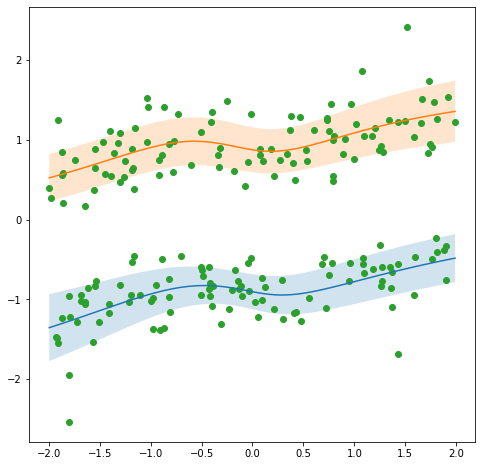

In [17]:
plt.figure(figsize=(8,8))
xs = t.linspace(data_X.min(), data_X.max(), 100)
xs_in = xs.unsqueeze(1).expand(100, -1, -1).to(device=device, dtype=dtype)
output, _, _ = bf.propagate(bmdn, xs_in)
pi, mu, sigma = output
pi = pi.mean(0).detach().cpu()
mu = mu.mean(0).detach().cpu()
sigma = sigma.mean(0).detach().cpu()

plt.plot(xs, mu[:,0])
plt.plot(xs, mu[:,1])

plt.fill_between(xs, mu[:,0]+sigma[:,0], mu[:,0]-sigma[:,0], alpha=0.2)
plt.fill_between(xs, mu[:,1]+sigma[:,1], mu[:,1]-sigma[:,1], alpha=0.2)

plt.scatter(data_X,data_y)

In [ ]:
# old code:
        continue
        
       

        
        opt.zero_grad()
        output, logpq, _ = bf.propagate(bnn, eval_X)
        ys = output.mean(0).reshape((train_batch, 2))
        grads = ((ys[:,0]-ys[:,1]) / div)
        # where all points are larger than y, grad = smallest - y
        #grads = grads + coefs
        grads = t.log(grads)
        # grads = t.log(((ys[:,0]-ys[:,1]) / div) * coefs)
        ll = -(grads.sum())
        ll = ll/(train_batch)
        lpq = (logpq/(data_size*2)).mean()
        (-(ll + lpq)).backward()
        opt.step()


        """
        continue
        ys.transpose(0,1).reshape((train_batch, 2))
        ll = t.tensor([0]).to(device=device, dtype=dtype)
        
        # use this to find the taus at which to evaluate: 2 per batch point
        for i in range(train_batch):
            idx = i * grid_size
            for j in range(grid_size-1):
                if j == 0 and ys[idx] > batch_y[i]:
                    #print("ALL VALUES LARGER THAN Y")
                    # if all values are larger than y: a very large gradient indicates low density
                    #eval_X.append(batch_X[idx+j])
                    g = (ys[idx+j+1] - ys[idx+j]) / div
                    ll = ll - t.log(g)
                    break
                if j == grid_size-2 and ys[idx+j] < batch_y[i]:
                    #eval_X.append(batch_X[idx+j])
                    #print("ALL VALUES LESS THAN Y")
                    # all values are less than y:
                    g = (ys[idx+grid_size-1] - ys[idx+grid_size-2]) / div
                    ll = ll - t.log(g)
                    break
                if ys[idx+j] <= batch_y[i] and batch_y[i] <= ys[idx+j+1]:
                    #eval_X.append(batch_X[idx+j])
                    #print("target y val:", batch_y[i])
                    #print("smaller val:", ys[(i*grid_size)+j])
                    #print("bigger val:", ys[(i*grid_size)+j+1])
                    g = (ys[idx+j+1] - ys[idx+j]) / div
                    #print("gradient val:", g)
                    ll = ll + t.log(g)
                    break

        ll = -(ll/train_batch)
        lpq = (logpq/data_size).mean()
        with t.no_grad():
            lls.append(ll)
            lpqs.append(lpq)
        (-(ll + lpq)).backward()
        opt.step()
        #break
        """
        
        """
        # Purely vector-function based approach
        output, logpq, _ = bf.propagate(bnn, batch_X.expand(samples, -1, -1))
        ys = output.mean(0) # average across all the samples
        ys = ys.transpose(0,1).reshape((train_batch, grid_size))
        by = batch_y.expand(-1, grid_size) 
        diffs = (ys[:,1:] - ys[:,:-1])
        mask = t.logical_and(ys.lt(by)[:,:-1], ys.gt(by)[:,1:])
        grads = t.log(diffs.masked_select(mask)/div)
        print(grads)
        ll = (-grads.sum())/batch_X.shape[0]
        lpq = (logpq/(batches * batch_X.shape[0])).mean()
        with t.no_grad():
            lls.append(ll.detach().cpu())
            lpqs.append(lpq.detach().cpu())
        (-(ll + lpq)).backward()
        opt.step()
        """
    #break

# want this increasing slowly
#plt.plot(t.arange(len(lls)), lls, c='b')
# want this descresing slowly
#plt.plot(t.arange(len(lpqs)), lpqs, c='r')